# Predicción de la demanda de energía eléctrica.

## Instalación de las librerías requeridas

In [6]:
#!pip install lightgbm

Instalación de la librería skforecast (No está preinstalada en colab)

In [7]:
!pip install skforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.8/424.8 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.9 MB/s eta 0:00:00


Librerías para el tratamiento de datos

In [8]:
import numpy as np
import pandas as pd

Librerías para dibujado de gráficos

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('fivethirtyeight')

Librerías para el modelado (Forecasting)

In [10]:
from sklearn.linear_model import Ridge
# Regresor de Gradient Boosting
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [11]:
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Carga de datos

In [13]:

from google.colab import drive
drive.mount('/content/drive')
datos = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Series temporales/Datos/vic_elec.csv", sep=',', index_col=0)
datos.info()

'\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\ndatos = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Series temporales/Datos/vic_elec.csv", sep=\',\', index_col=0)\ndatos.info()\n'

In [14]:
datos.describe(include= "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Time,52608,52608,2011-12-31T13:00:00Z,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Demand,52608.0,NaN,NaN,NaN,4665.432826,874.273645,2857.945728,3969.464472,4634.706032,5244.325424,9345.004346
Temperature,52608.0,NaN,NaN,NaN,16.265071,5.658849,1.5,12.3,15.4,19.4,43.2
Date,52608,1096,2013-04-07,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Holiday,52608,2,False,51120,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
datos

,Time,Demand,Temperature,Date,Holiday
0,2011-12-31T13:00:00Z,4382.825174,21.40,2012-01-01,True
1,2011-12-31T13:30:00Z,4263.365526,21.05,2012-01-01,True
2,2011-12-31T14:00:00Z,4048.966046,20.70,2012-01-01,True
3,2011-12-31T14:30:00Z,3877.563330,20.55,2012-01-01,True
4,2011-12-31T15:00:00Z,4036.229746,20.40,2012-01-01,True
...,...,...,...,...,...
52603,2014-12-31T10:30:00Z,3873.448714,19.00,2014-12-31,False
52604,2014-12-31T11:00:00Z,3791.637322,18.50,2014-12-31,False
52605,2014-12-31T11:30:00Z,3724.835666,17.70,2014-12-31,False
52606,2014-12-31T12:00:00Z,3761.886854,17.30,2014-12-31,False


La columna Date es la fecha a la que fueron recopilados los datos.

In [16]:
# Se elimina la columna Date
datos = datos.drop(columns='Date')

La columna Holiday no genera error ya que es booleana y se trata como 0-1.

### Columna Time a formato DateTime y a índice
 La columna Time no está con formato DateTime. Hay que transformarla.

In [17]:
datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')

Y convertimos esa columna en índice

In [18]:
datos = datos.set_index('Time')
datos = datos.asfreq('30min')
datos = datos.sort_index()

In [19]:
datos.describe(include= "all", datetime_is_numeric=True).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Demand,52608.0,NaN,NaN,NaN,4665.432826,874.273645,2857.945728,3969.464472,4634.706032,5244.325424,9345.004346
Temperature,52608.0,NaN,NaN,NaN,16.265071,5.658849,1.5,12.3,15.4,19.4,43.2
Holiday,52608,2,False,51120,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
datos

,Demand,Temperature,Holiday
Time,,,
2011-12-31 13:00:00,4382.825174,21.40,True
2011-12-31 13:30:00,4263.365526,21.05,True
2011-12-31 14:00:00,4048.966046,20.70,True
2011-12-31 14:30:00,3877.563330,20.55,True
2011-12-31 15:00:00,4036.229746,20.40,True
...,...,...,...
2014-12-31 10:30:00,3873.448714,19.00,False
2014-12-31 11:00:00,3791.637322,18.50,False
2014-12-31 11:30:00,3724.835666,17.70,False


#### Verificar que un índice temporal está completo

In [21]:
# Construimos un rango completo de tiempo desde el mínimo al máximo y con saltos iguales a la frecuencia...
rango_completo = pd.date_range(
    start=datos.index.min(),
    end=datos.index.max(),
    freq=datos.index.freq)

# ...y comprobamos que la columna índice (Time) coincide en todos los puntos
(datos.index == rango_completo).all()

True

#### Agregado en intervalos de 1H

Aunque los datos se encuentran en intervalos de 30 minutos, el objetivo es crear un modelo capaz de predecir la demanda eléctrica con frecuencia horaria, por lo que se tienen que agregar los datos. Este tipo de transformación es muy sencilla si se combina el índice de tipo temporal de pandas y su método resample().

Es muy importante utilizar correctamente los argumentos closed='left' y label='right' para no introducir en el entrenamiento información a futuro (leakage)). Supóngase que se dispone de valores para las 10:10, 10:30, 10:45, 11:00, 11:12 y 11:30. Si se quiere obtener el promedio horario, el valor asignado a las 11:00 debe calcularse utilizando los valores de las 10:10, 10:30 y 10:45; y el de las 12:00, con el valor de las 11:00, 11:12 y 11:30.

Para el valor promedio de las 11:00 no se incluye el valor puntual de las 11:00 por que, en la realidad, en ese momento exacto no se dispone todavía del valor.

In [22]:
datos = datos.resample(rule='H', closed='left', label ='right').mean()
datos

,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00,3950.913495,20.325,1.0
2011-12-31 17:00:00,3627.860675,19.850,1.0
2011-12-31 18:00:00,3396.251676,19.025,1.0
...,...,...,...
2014-12-31 09:00:00,4069.625550,21.600,0.0
2014-12-31 10:00:00,3909.230704,20.300,0.0
2014-12-31 11:00:00,3900.600901,19.650,0.0


#### Dummy de día de la semana

Creación de una variable categórica dummyficada con el día de la semana ya que el consumo varía en función del día de la semana.

Lunes 0, ... Domingo 6

In [23]:
datos["dia_semana"] = datos.index.dayofweek
datos.head()

,Demand,Temperature,Holiday,dia_semana
Time,,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0,5
2011-12-31 15:00:00,3963.264688,20.625,1.0,5
2011-12-31 16:00:00,3950.913495,20.325,1.0,5
2011-12-31 17:00:00,3627.860675,19.850,1.0,5
2011-12-31 18:00:00,3396.251676,19.025,1.0,5


In [24]:
datos = pd.get_dummies(datos, columns = ["dia_semana"])
datos.head(15)

,Demand,Temperature,Holiday,dia_semana_0,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6
Time,,,,,,,,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0,0,0,0,0,0,1,0
2011-12-31 15:00:00,3963.264688,20.625,1.0,0,0,0,0,0,1,0
2011-12-31 16:00:00,3950.913495,20.325,1.0,0,0,0,0,0,1,0
2011-12-31 17:00:00,3627.860675,19.850,1.0,0,0,0,0,0,1,0
2011-12-31 18:00:00,3396.251676,19.025,1.0,0,0,0,0,0,1,0
2011-12-31 19:00:00,3317.992230,18.725,1.0,0,0,0,0,0,1,0
2011-12-31 20:00:00,3274.052232,18.675,1.0,0,0,0,0,0,1,0
2011-12-31 21:00:00,3432.421122,19.650,1.0,0,0,0,0,0,1,0
2011-12-31 22:00:00,3650.038153,21.775,1.0,0,0,0,0,0,1,0


El set de datos empieza el 2011-12-31 14:00:00 y termina el 2014-12-31 13:00:00. <br>
Se descartan los primeros 10 y los últimos 13 registros para que empiece el 2012-01-01 00:00:00 y termine el 2014-12-30 23:00:00.

## Separación Train, Validación y Test
Además, para poder optimizar los hiperparámetros del modelo y evaluar su capacidad predictiva, se dividen los datos en 3 conjuntos, uno de entrenamiento, otro de validación y otro de test.

In [25]:
# Separación datos train-val-test
# ==============================================================================
datos = datos.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
fin_train = '2013-12-31 23:59:00'
fin_validacion = '2014-11-30 23:59:00'
datos_train = datos.loc[: fin_train, :]
datos_val   = datos.loc[fin_train:fin_validacion, :]
datos_test  = datos.loc[fin_validacion:, :]

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train      : 2012-01-01 00:00:00 --- 2013-12-31 23:00:00  (n=17544)
Fechas validacion : 2014-01-01 00:00:00 --- 2014-11-30 23:00:00  (n=8016)
Fechas test       : 2014-12-01 00:00:00 --- 2014-12-30 23:00:00  (n=720)


De esta manera:
- Entreno con los datos de 2012 y 2013
- Valido el entrenamiento con los datos de 2014 hasta el 30 de Noviembre
- Uso el modelo para predecir Diciembre

# Exploración gráfica

Cuando se quiere generar un modelo de forecasting, es importante representar los valores de la serie temporal. Esto permite identificar patrones tales como tendencias y estacionalidad.

## Serie temporal completa

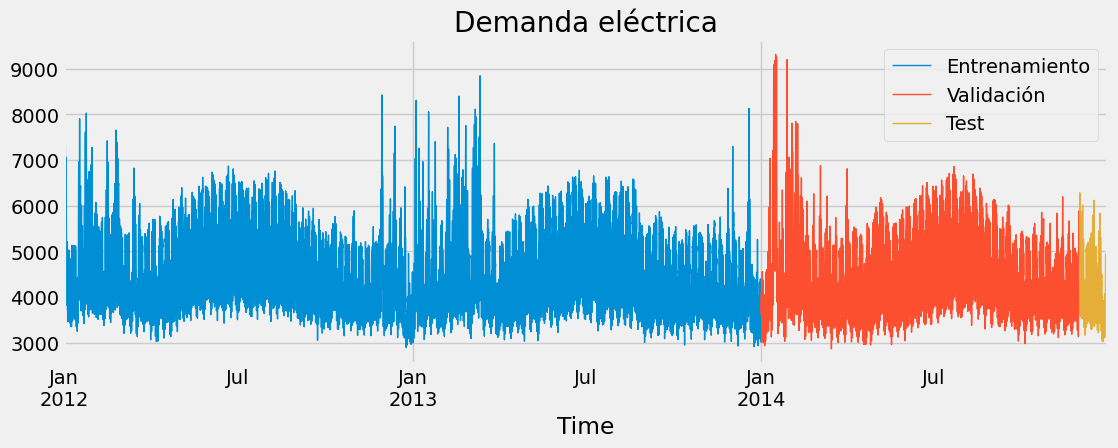

In [26]:
# Gráfico serie temporal
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 4))
datos_train.Demand.plot(ax=ax, label='Entrenamiento', linewidth=1)
datos_val.Demand.plot(ax=ax, label='Validación', linewidth=1)
datos_test.Demand.plot(ax=ax, label='Test', linewidth=1)
ax.set_title('Demanda eléctrica')
ax.legend();

El gráfico anterior muestra que la demanda eléctrica tiene estacionalidad anual. Se observa un incremento centrado en el mes de Julio y picos de demanda muy acentuados entre enero y marzo.

### Sección ampliada de la serie temporal

Debido a la varianza de la serie temporal, no es posible apreciar con un solo gráfico el posible patrón intradiario.

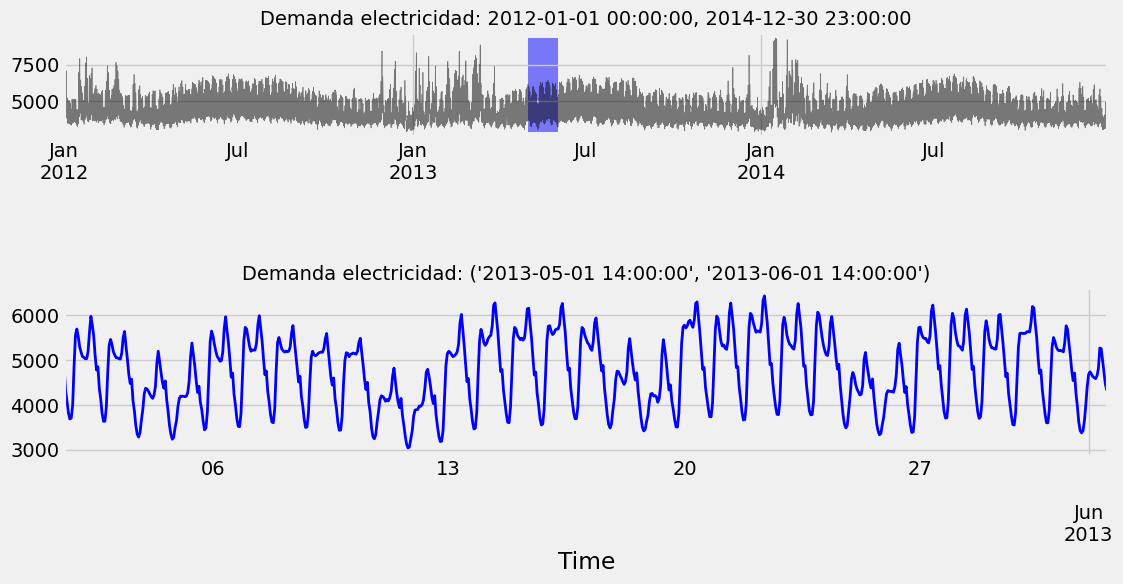

In [27]:
zoom = ('2013-05-01 14:00:00','2013-06-01 14:00:00')

fig = plt.figure(figsize=(12, 6))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)

main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])

datos.Demand.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(datos.Demand)
max_y = max(datos.Demand)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')

datos.loc[zoom[0]: zoom[1]].Demand.plot(ax=zoom_ax, color='blue', linewidth=2)

main_ax.set_title(f'Demanda electricidad: {datos.index.min()}, {datos.index.max()}', fontsize=14)
zoom_ax.set_title(f'Demanda electricidad: {zoom}', fontsize=14)
plt.subplots_adjust(hspace=1)

Al aplicar zoom sobre la serie temporal, se hace patente una clara estacionalidad semanal, con consumos más elevados durante la semana laboral (lunes a viernes) y menor en los fines de semana. Se observa también que existe una clara correlación entre el consumo de un día con el del día anterior.

**Estacionalidad anual, semanal y diaria**

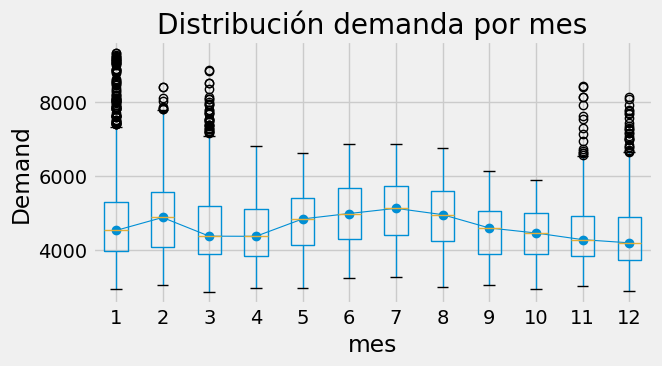

In [28]:
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['mes'] = datos.index.month
datos.boxplot(column='Demand', by='mes', ax=ax,)
datos.groupby('mes')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

Se observa que hay una estacionalidad anual, con valores de demanda (mediana) superiores en los meses de Junio, Julio y Agosto, y con elevados picos de demanda en los meses de Noviembre, Diciembre, Enero, Febrero y Marzo.

**Gráfico boxplot para estacionalidad diaria**

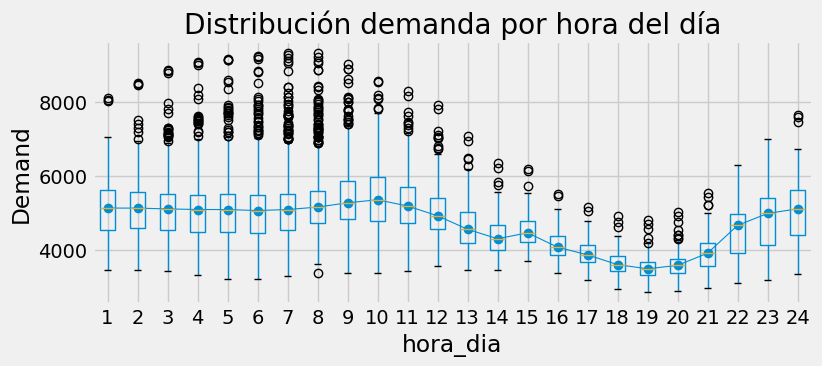

In [29]:
fig, ax = plt.subplots(figsize=(9, 3.5))
datos['hora_dia'] = datos.index.hour + 1
datos.boxplot(column='Demand', by='hora_dia', ax=ax)
datos.groupby('hora_dia')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por hora del día')
fig.suptitle('');

También existe una estacionalidad diaria, la demanda se reduce entre las 16 y las 21 horas.

**Días festivos y no festivos.** Grafico violinplot

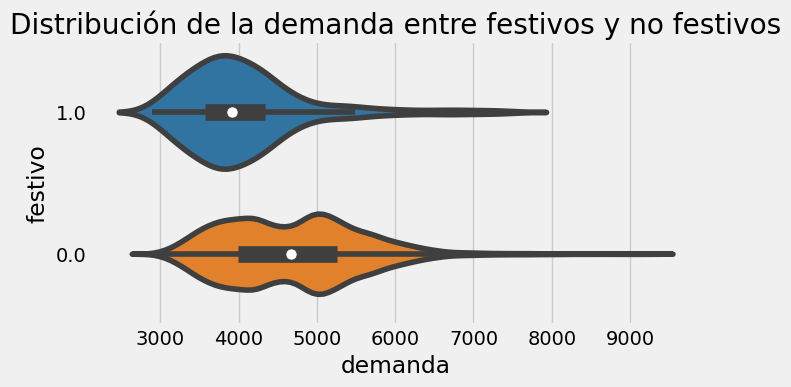

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.5))
sns.violinplot(
    x       = 'Demand',
    y       = 'Holiday',
    data    = datos.assign(Holiday = datos.Holiday.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribución de la demanda entre festivos y no festivos')
ax.set_xlabel('demanda')
ax.set_ylabel('festivo');

Los días festivos tienden a tener menor consumo.

## Gráficos de autocorrelación


Un gráfico de autocorrelación muestra en el eje horizontal los retrasos o lags, que representan los períodos anteriores en la serie de tiempo con los que se está calculando la correlación. En el eje vertical se muestra el valor de la correlación, que varía entre -1 y 1.

Al analizar un gráfico de autocorrelación, se pueden obtener varias informaciones importantes:

1. Autocorrelación: El gráfico muestra el nivel de correlación entre los valores pasados de la serie de tiempo y los valores actuales en diferentes retrasos. Se puede observar si existe autocorrelación positiva o negativa, lo cual indica una dependencia lineal entre los valores pasados y presentes.

2. Patrones de temporada: Si la serie de tiempo exhibe un patrón estacional, es decir, si los valores se repiten en períodos regulares, el gráfico de autocorrelación mostrará picos significativos en los retrasos correspondientes a los múltiplos de la longitud de la estacionalidad. Estos picos indican la presencia de autocorrelación en esos retrasos específicos, lo cual sugiere un patrón estacional en los datos.

3. Significancia estadística: Junto al gráfico de autocorrelación, a menudo se muestra una banda sombreada o líneas horizontales para indicar los límites de confianza estadística. Si los coeficientes de autocorrelación se encuentran fuera de estos límites, se consideran estadísticamente significativos y sugieren una correlación real en esos retrasos.

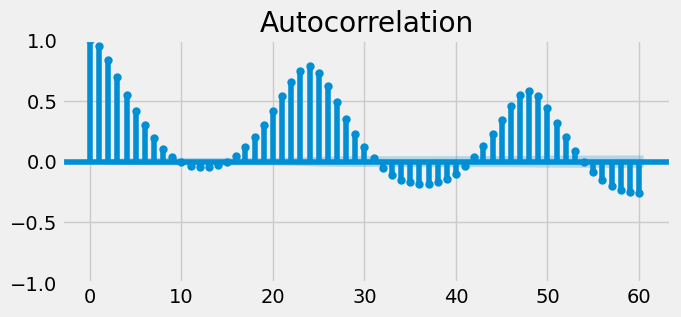

In [31]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(7, 3))
plot_acf(datos['Demand'], ax=ax, lags=60)
plt.show()

Aquí podemos ver alta correlción en intervalos de 24, 48... horas

**Gráfico autocorrelación parcial**

El gráfico de autocorrelación parcial (PACF por sus siglas en inglés) sirve para analizar la autocorrelación parcial en una serie de tiempo. La autocorrelación parcial mide la correlación entre los valores pasados de la serie de tiempo y los valores actuales, **eliminando la influencia de los valores intermedios.**

Un gráfico de autocorrelación parcial muestra en el eje horizontal los retrasos o lags, que representan los períodos anteriores en la serie de tiempo con los que se está calculando la correlación parcial. En el eje vertical se muestra el valor de la correlación parcial, que también varía entre -1 y 1.

Al analizar un gráfico de autocorrelación parcial, se pueden obtener varias informaciones importantes:

1. Autocorrelación parcial: El gráfico muestra el nivel de correlación parcial entre los valores pasados de la serie de tiempo y los valores actuales en diferentes retrasos, eliminando la influencia de los valores intermedios. La autocorrelación parcial proporciona una medida más precisa de la correlación directa entre los valores pasados y presentes.

2. Identificación de órdenes de modelos AR: Los gráficos de autocorrelación parcial se utilizan comúnmente para identificar los órdenes de modelos autorregresivos (AR). Los picos significativos en los retrasos indican los órdenes AR correspondientes. Por ejemplo, si hay un pico significativo en el retraso 1 y ningún otro pico significativo después de ese, sugiere un posible modelo AR(1).

3. Significancia estadística: Al igual que en el gráfico de autocorrelación, se pueden mostrar límites de confianza estadística en el gráfico de autocorrelación parcial. Los picos que exceden estos límites se consideran estadísticamente significativos y sugieren una correlación parcial real en esos retrasos.

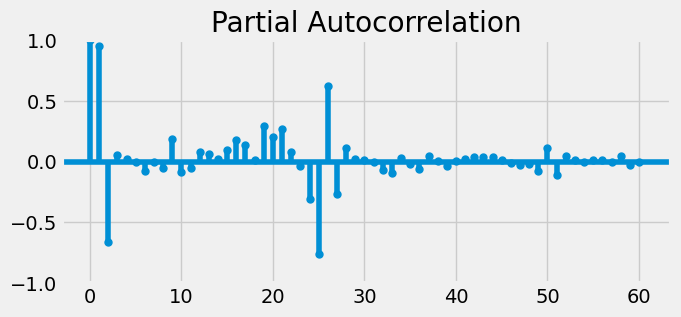

In [32]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(figsize=(7, 3))
plot_pacf(datos["Demand"], ax=ax, lags=60)
plt.show()

Los gráficos de autocorrelación y autocorrelación parcial muestran una clara asociación entre la demanda de una hora y las horas anteriores, así como entre la demanda de una hora y la demanda de esa misma hora los días anteriores. Este tipo de correlación, es un **indicativo de que los modelos autorregresivos pueden funcionar bien.**

## Modelo autoregresivo recursivo


Se crea y entrena un modelo autorregresivo recursivo (ForecasterAutoreg) a partir de un modelo de regresión lineal con penalización Ridge y una ventana temporal de 24 lags. Esto último significa que, para cada predicción, se utilizan como predictores la demanda de las 24 horas anteriores.

### Crear y entrenar Forecaster

Utilizo un regresor al que le pido que agrupe los datos en grupos de 24 lags (24 horas)

El regresor Ridge es un modelo de regresión lineal que incorpora una penalización en la función de costo para evitar el sobreajuste y mejorar la generalización del modelo. La penalización se basa en la suma de los cuadrados de los coeficientes del modelo multiplicada por el valor de alpha. Al aumentar el valor de alpha, se incrementa la fuerza de la penalización, lo que lleva a coeficientes más pequeños y a un modelo más simplificado.

El parámetro alpha controla el equilibrio entre ajustar los datos de entrenamiento y mantener la simplicidad del modelo. Un valor más alto de alpha aumenta la penalización, lo que puede reducir el sobreajuste pero también conducir a un ajuste insuficiente si se excede. Por otro lado, un valor más bajo de alpha disminuye la penalización, permitiendo que los coeficientes se ajusten más a los datos de entrenamiento, lo que puede llevar a un mayor riesgo de sobreajuste.

In [33]:
forecaster = ForecasterAutoreg(
                regressor     = Ridge(),
                lags          = 24,
                transformer_y = StandardScaler()
             )

forecaster.fit(y=datos.loc[:fin_validacion, 'Demand'])
forecaster

ForecasterAutoreg 
Regressor: Ridge() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-12-17 20:43:32 
Last fit date: 2023-12-17 20:43:32 
Skforecast version: 0.11.0 
Python version: 3.10.12 
Forecaster id: None 

### Predicción (backtest)

Se evalúa el comportamiento que habría tenido el modelo si se hubiese entrenado con los datos desde 2012-01-01 00:00 al 2014-11-30 23:59 y, después, a las 23:59 de cada día, se predijesen las 24 horas siguientes. A este tipo de evaluación se le conoce como backtesting, y puede aplicarse fácilmente con la función backtesting_forecaster(). Esta función devuelve, además de las predicciones, una métrica de error.

In [34]:
metrica, predicciones = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = datos.Demand,
                            initial_train_size = len(datos.loc[:fin_validacion]),
                            fixed_train_size   = False,
                            steps      = 24,
                            metric     = 'mean_absolute_error',
                            refit      = False,
                            verbose    = True)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 25560
Number of observations used for backtesting: 720
    Number of folds: 30
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-01 00:00:00 -- 2014-12-01 23:00:00  (n=24)
Fold: 1
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-02 00:00:00 -- 2014-12-02 23:00:00  (n=24)
Fold: 2
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-03 00:00:00 -- 2014-12-03 23:00:00  (n=24)
Fold: 3
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-04 00:00:00 -- 2014-12-04 23:00:00  (n=24)
Fold: 4
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-05

  0%|          | 0/30 [00:00<?, ?it/s]

### Representación gráfica de la predicción

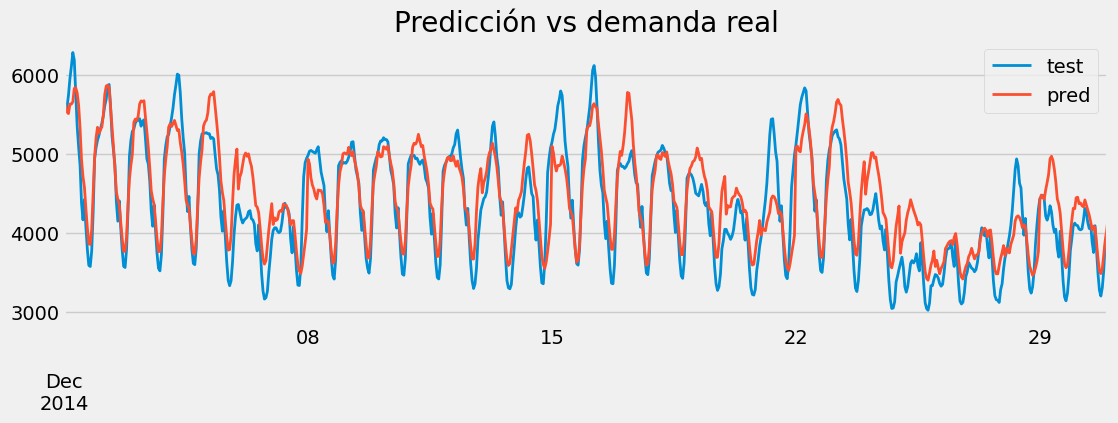

In [35]:
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(ax=ax, linewidth=2, label='test')
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [36]:
print(f'Error backtest: {metrica}')

Error backtest: 289.5191331582498


## Optimización de hiperparámetros (tuning)
En el objeto ForecasterAutoreg entrenado, se han utilizado los primeros 24 lags y un modelo Ridge con los hiperparámetros por defecto. Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados.

Con el objetivo de identificar la mejor combinación de lags e hiperparámetros, se recurre a un Grid Search. Este proceso consiste en entrenar un modelo con cada combinación de hiperparámetros y lags, y evaluar su capacidad predictiva mediante backtesting. En el proceso de búsqueda, es importante evaluar los modelos utilizando únicamente los datos de validación y no incluir los de test, estos se utilizan solo en último lugar para evaluar al modelo final.

### Grid search de hiperparámetros

In [37]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor     = Ridge(),
                lags          = 24,
                transformer_y = StandardScaler()# Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Hiperparámetros del regresor
param_grid = {'alpha': np.logspace(-3, 5, 10)}

resultados_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = datos.loc[:fin_validacion, 'Demand'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 24,
                        metric      = 'mean_absolute_error',
                        refit       = False,
                        initial_train_size = len(datos[:fin_train]),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
                  )

Number of models compared: 30.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'alpha': 215.44346900318823}
  Backtesting metric: 257.84309845082885



In [38]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

,lags,params,mean_absolute_error,alpha
26,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 215.44346900318823},257.843098,215.443469
25,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 27.825594022071257},290.527024,27.825594
24,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 3.593813663804626},306.626903,3.593814
23,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.46415888336127775},309.392653,0.464159
22,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.05994842503189409},309.775993,0.059948
21,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.007742636826811269},309.825950,0.007743
20,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.001},309.832409,0.001000
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.001},325.041130,0.001000
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.007742636826811269},325.043580,0.007743
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.05994842503189409},325.062545,0.059948


Los mejores resultados se obtienen si se utilizan los lags [1, 2, 3, 23, 24, 25, 47, 48, 49] y una configuración de Ridge {'alpha': 215.44}. Al indicar return_best = True en la función grid_search_forecaster(), al final del proceso, se reentrena automáticamente el objeto forecaster con la mejor configuración encontrada y el set de datos completo.

In [39]:
forecaster

ForecasterAutoreg 
Regressor: Ridge(alpha=215.44346900318823) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 49 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 215.44346900318823, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-12-17 20:43:33 
Last fit date: 2023-12-17 20:44:26 
Skforecast version: 0.11.0 
Python version: 3.10.12 
Forecaster id: None 

### Backtest con el conjunto de test
Una vez identificado y entrenado el mejor modelo, se calcula su error al predecir los datos de test.

  0%|          | 0/30 [00:00<?, ?it/s]

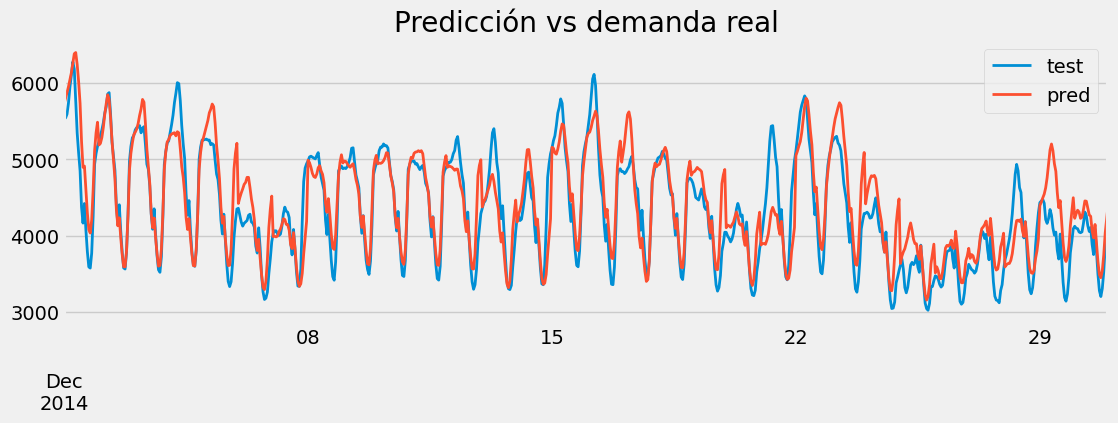

In [40]:
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = datos.Demand,
                            initial_train_size = len(datos[:fin_validacion]),
                            fixed_train_size   = False,
                            steps              = 24,
                            metric             = 'mean_absolute_error',
                            refit              = False,
                            verbose            = False
                        )

fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [41]:
print(f'Error backtest: {metrica}')

Error backtest: 251.92726486972396


Tras la optimización de lags e hiperparámetros, se ha conseguido reducir el error de predicción de 289.5 a 251.9.

## Intervalos de predicción
Un intervalo de predicción define el intervalo dentro del cual es de esperar que se encuentre el verdadero valor de  y
  con una determinada probabilidad. Por ejemplo, es de esperar que el intervalo de predicción (1, 99) contenga el verdadero valor de la predicción con un 98% de probabilidad.

Rob J Hyndman y George Athanasopoulos, listan en su libro Forecasting: Principles and Practice mútiples formas de estimar intervalos de predicción, la mayoría de los cuales requieren que los residuos (errores) del modelo se distribuyan de forma normal. Cuando no se puede asumir esta propiedad, se puede recurrir a bootstrapping, que solo asume que los residuos no están correlacionados. Este es el método utilizado en la librería skforecast para los modelos de tipo ForecasterAutoreg y ForecasterAutoregCustom.

In [42]:
# Backtest del conjunto de test con intervalos de predicción
# ==============================================================================
metric, predicciones = backtesting_forecaster(
                            forecaster          = forecaster,
                            y                   = datos.Demand,
                            initial_train_size  = len(datos.Demand[:fin_validacion]),
                            fixed_train_size    = False,
                            steps               = 24,
                            metric              = 'mean_absolute_error',
                            interval            = [10, 90],
                            n_boot              = 500,
                            in_sample_residuals = True,
                            verbose             = False
                       )

print('Métrica backtesting:', metric)
predicciones.head(5)

  0%|          | 0/30 [00:00<?, ?it/s]

Métrica backtesting: 251.92726486972396


,pred,lower_bound,upper_bound
2014-12-01 00:00:00,5727.844947,5598.931844,5849.598860
2014-12-01 01:00:00,5802.807448,5599.126464,5974.887546
2014-12-01 02:00:00,5879.948808,5619.868497,6113.714851
2014-12-01 03:00:00,5953.414468,5657.436246,6239.937101
2014-12-01 04:00:00,6048.594433,5697.672143,6342.846047


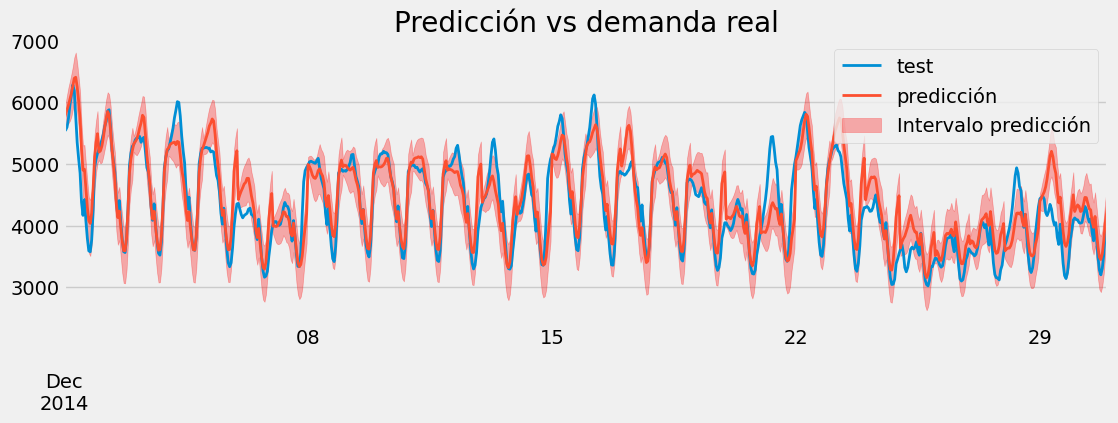

In [43]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones['pred'].plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    alpha = 0.3,
    color = 'red',
    label = 'Intervalo predicción'
)
ax.legend();

In [44]:
# Cobertura del intervalo predicho
# ==============================================================================
dentro_intervalo = np.where(
                     (datos.loc[fin_validacion:, 'Demand'] >= predicciones['lower_bound']) & \
                     (datos.loc[fin_validacion:, 'Demand'] <= predicciones['upper_bound']),
                     True,
                     False
                   )

cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {round(100*cobertura, 2)} %")

Cobertura del intervalo predicho: 79.03 %


El intervalo predicho tiene una cobertura inferior a la que cabría esperar (80%). Esto puede deberse al error marcadamente elevado que comete el modelo para los días 21, 24 y 25. Estos días están dentro del periodo vacacional de navidad, que suele caracterizarse por un comportamiento de consumo distinto al resto del mes

## Predicción diaria anticipada


En el apartado anterior, se evaluó el modelo asumiendo que las predicciones del día siguiente se ejecutan justo al final del día anterior. En la práctica, esto no resulta muy útil ya que, para las primeras horas del día, apenas se dispone de anticipación.

Supóngase ahora que, para poder tener suficiente margen de acción, a las 11:00 horas de cada día se tienen que generar las predicciones del día siguiente. Es decir, a las 11:00 del dia  D
  se tienen que predecir las horas [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] de ese mismo día, y las horas [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] del día  D+1
 . Esto implica que se tienen que predecir un total de 36 horas a futuro.

El proceso de backtesting adaptado a este escenario es:
- A las 11:00h del primer día del conjunto de test, se predicen las 36 siguientes horas (las 12 horas que quedan del día más las 24 horas de el día siguiente).
- Se almacenan solo las predicciones del día siguiente, es decir, de la posición 12 en adelante.
- Se añaden los datos de test hasta las 11:00 del día siguiente.
- Se repite el proceso.
- De esta forma, a las 11:00h de cada día, el modelo tiene acceso a los valores reales de demanda registrados hasta ese momento.

Este proceso puede realizarse fácilmente con el método predict() de un objeto ForecasterAutoreg. Si no se le indica nada, la predicción se inicia después del último valor de entrenamiento, pero, si se le especifica el argumento last_window, utiliza estos valores como punto de partida.

In [45]:
def backtest_predict_next_24h(forecaster, y, hour_init_prediction, exog=None,
                              verbose=False):
    '''
    Backtest ForecasterAutoreg object when predicting 24 hours of day D+1
    statring at specific hour of day D.

    Parameters
    ----------
    forecaster : ForecasterAutoreg
        ForecasterAutoreg object already trained.

    y : pd.Series with datetime index sorted
        Test time series values.

    exog : pd.Series or pd.Dataframe with datetime index sorted
        Test values of exogen variable.

    hour_init_prediction: int
        Hour of day D to start predicciones of day D+1.


    Returns
    -------
    predicciones: pd.Series
        Value of predicciones.

    '''

    y = y.sort_index()
    if exog is not None:
        exog = exog.sort_index()

    dummy_steps = 24 - (hour_init_prediction + 1)
    steps = dummy_steps + 24

    # First position of `hour_init_prediction` in the series where there is enough
    # previous window to calculate lags.
    for datetime in y.index[y.index.hour == hour_init_prediction]:
        if len(y[:datetime]) >= len(forecaster.last_window):
            datetime_init_backtest = datetime
            print(f"Backtesting starts at day: {datetime_init_backtest}")
            break

    days_backtest = np.unique(y[datetime_init_backtest:].index.date)
    days_backtest = pd.to_datetime(days_backtest)
    days_backtest = days_backtest[1:]
    print(f"Days predicted in the backtesting: {days_backtest.strftime('%Y-%m-%d').values}")
    print('')
    backtest_predicciones = []

    for i, day in enumerate(days_backtest):
        # Start and end of the last window used to create the lags
        end_window = (day - pd.Timedelta(1, unit='day')).replace(hour=hour_init_prediction)
        start_window = end_window - pd.Timedelta(forecaster.max_lag, unit='hour')
        last_window = y.loc[start_window:end_window]

        if exog is None:
            if verbose:
                print(f"Forecasting day {day.strftime('%Y-%m-%d')}")
                print(f"Using window from {start_window} to {end_window}")

            pred = forecaster.predict(steps=steps, last_window=last_window)

        else:
            start_exog_window = end_window + pd.Timedelta(1, unit='hour')
            end_exog_window   = end_window + pd.Timedelta(steps, unit='hour')
            exog_window = exog.loc[start_exog_window:end_exog_window]
            exog_window = exog_window

            if verbose:
                print(f"Forecasting day {day.strftime('%Y-%m-%d')}")
                print(f"    Using window from {start_window} to {end_window}")
                print(f"    Using exogen variable from {start_exog_window} to {end_exog_window}")

            pred = forecaster.predict(steps=steps, last_window=last_window, exog=exog_window)

        # Only store predicciones of day D+1
        pred = pred[dummy_steps:]
        backtest_predicciones.append(pred)

    backtest_predicciones = np.concatenate(backtest_predicciones)
    # Add datetime index
    backtest_predicciones = pd.Series(
                             data  = backtest_predicciones,
                             index = pd.date_range(
                                        start = days_backtest[0],
                                        end   = days_backtest[-1].replace(hour=23),
                                        freq  = 'h'
                                    )
                           )

    return backtest_predicciones

In [46]:
# Backtest
# ==============================================================================
predicciones = backtest_predict_next_24h(
                    forecaster = forecaster,
                    y          = datos.loc[fin_validacion:, 'Demand'],
                    hour_init_prediction = 11,
                    verbose    = False
                )

Backtesting starts at day: 2014-12-03 11:00:00
Days predicted in the backtesting: ['2014-12-04' '2014-12-05' '2014-12-06' '2014-12-07' '2014-12-08'
 '2014-12-09' '2014-12-10' '2014-12-11' '2014-12-12' '2014-12-13'
 '2014-12-14' '2014-12-15' '2014-12-16' '2014-12-17' '2014-12-18'
 '2014-12-19' '2014-12-20' '2014-12-21' '2014-12-22' '2014-12-23'
 '2014-12-24' '2014-12-25' '2014-12-26' '2014-12-27' '2014-12-28'
 '2014-12-29' '2014-12-30']



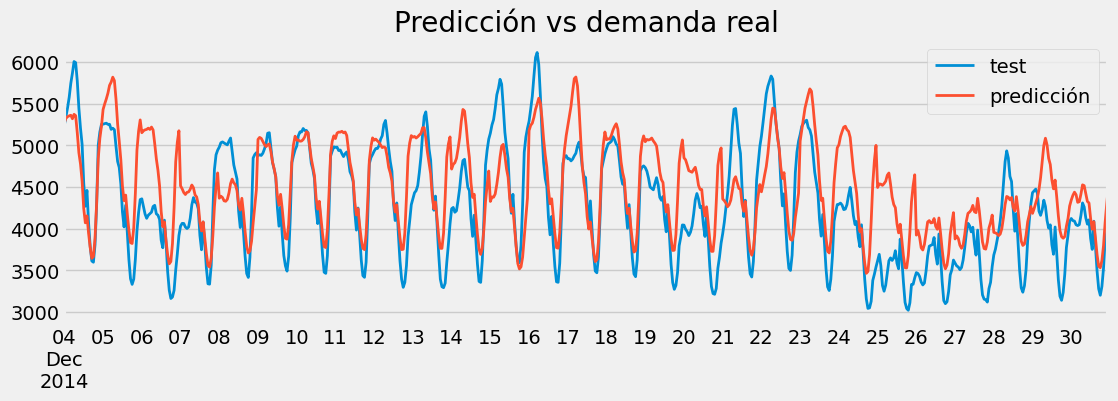

In [47]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [48]:
# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'Demand'],
            y_pred = predicciones
        )
print(f"Error de backtest: {error}")

Error de backtest: 394.50411574864256


Como era de esperar, al aumentar el horizonte de predicción, también lo hace el error de las predicciones.

## Importancia de los  predictores
Dado que el objeto ForecasterAutoreg utiliza modelos scikit-learn, una vez entrenado, se puede acceder a la importancia de los predictores. Cuando el regresor empleado es un LinearRegression(), Lasso() o Ridge(), la importancia queda reflejada en los coeficientes del modelo. En regresores GradientBoostingRegressor() o RandomForestRegressor(), la importancia de los predictores está basada en la reducción de impureza.

Nota: el método get_feature_importance() solo devuelve valores si el regresor utilizado dentro del forecaster tiene el atributo coef_ o feature_importances_.

In [49]:
# Importancia predictores
# ==============================================================================
forecaster.get_feature_importance()

AttributeError: ignored

## Forecasting con variables exógenas
En el ejemplo anterior, se han utilizado como predictores únicamente lags de la propia variable objetivo. En ciertos escenarios, es posible disponer de información sobre otras variables, cuyo valor a futuro se conoce, y que pueden servir como predictores adicionales en el modelo. Algunos ejemplos típicos son:
- Festivos (local, nacional...)
- Mes del año
- Día de la semana
- Hora del día

En este caso de uso, el análisis gráfico mostraba evidencias de que, los días festivos, la demanda es menor. Si un día es festivo o no, puede saberse a futuro, por lo que se puede emplear como variable exógena. Véase cómo afecta al modelo si se incluye como predictor la variable Holiday disponible en el set de datos.

### Entrenamiento del Forecaster
Se emplean los hiperparámetros y lags identificados como óptimos en el apartado anterior.

In [51]:
# Se convierte la columna Holiday de boolean a integer
datos.loc[:,'Holiday'] = datos['Holiday'].astype(int)
datos_train.loc[:,'Holiday'] = datos_train['Holiday'].astype(int)
datos_test.loc[:,'Holiday'] = datos_test['Holiday'].astype(int)

In [52]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor     = Ridge(alpha=215.44),
                lags          = [1, 2, 3, 23, 24, 25, 47, 48, 49],
                transformer_y = StandardScaler()
             )
forecaster.fit(y=datos.Demand[:fin_validacion], exog=datos.Holiday[:fin_validacion])
forecaster

ForecasterAutoreg 
Regressor: Ridge(alpha=215.44) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 49 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: Holiday 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 215.44, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-12-17 21:01:14 
Last fit date: 2023-12-17 21:01:14 
Skforecast version: 0.11.0 
Python version: 3.10.12 
Forecaster id: None 

## Predicción diaria anticipada
Se repite de nuevo el proceso de backtesting en el que, a las 11:00 horas de cada día, se tienen que obtener las predicciones del día siguiente. Esta vez, incluyendo como predictor si el día es festivo o no.

In [53]:
# Backtest
# ==============================================================================
predicciones = backtest_predict_next_24h(
                    forecaster = forecaster,
                    y          = datos.loc[fin_validacion:, 'Demand'],
                    exog       = datos.loc[fin_validacion:, 'Holiday'],
                    hour_init_prediction = 11,
                    verbose    = False
               )

Backtesting starts at day: 2014-12-03 11:00:00
Days predicted in the backtesting: ['2014-12-04' '2014-12-05' '2014-12-06' '2014-12-07' '2014-12-08'
 '2014-12-09' '2014-12-10' '2014-12-11' '2014-12-12' '2014-12-13'
 '2014-12-14' '2014-12-15' '2014-12-16' '2014-12-17' '2014-12-18'
 '2014-12-19' '2014-12-20' '2014-12-21' '2014-12-22' '2014-12-23'
 '2014-12-24' '2014-12-25' '2014-12-26' '2014-12-27' '2014-12-28'
 '2014-12-29' '2014-12-30']



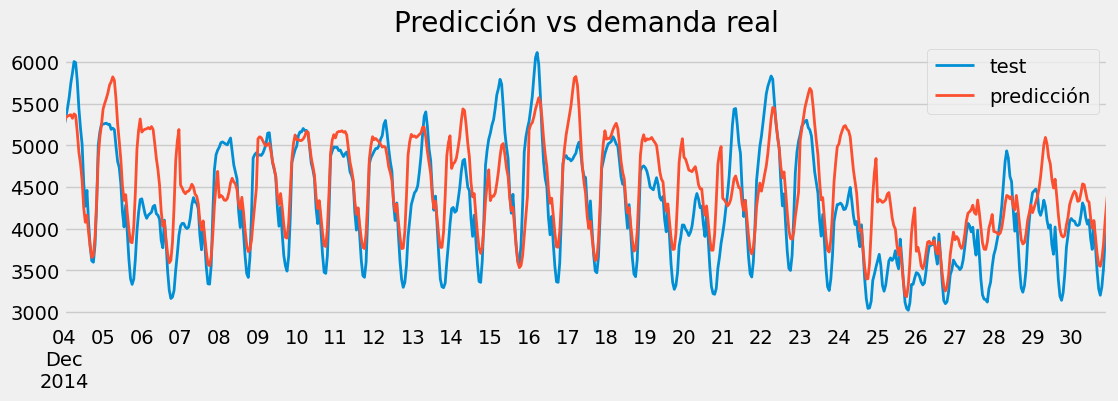

In [54]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [55]:
# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'Demand'],
            y_pred = predicciones
        )

print(f"Error de backtest: {error}")

Error de backtest: 378.34485976981233


Utilizando como variable exógena si el día es festivo o no, se consigue reducir ligeramente el error de predicción de 394.5 a 375.1. Véase qué ocurre al añadir, además de si el día anterior y siguiente son festivos, el día de la semana y hora del día.

In [56]:
# Creación de nuevas variables exógenas
# ==============================================================================
# Al ser datos  horarios y empezar a las 00:00 se tienen que desplazar los valores
# de 24 en 24.
datos.loc[:,'Holiday_day_before'] = datos['Holiday'].shift(24)
datos.loc[:,'Holiday_next_day']   = datos['Holiday'].shift(-24)
datos=datos.dropna()

datos.head(3)

,Demand,Temperature,Holiday,dia_semana_0,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6,mes,hora_dia,Holiday_day_before,Holiday_next_day
Time,,,,,,,,,,,,,,
2012-01-02 00:00:00,5262.895338,32.825,1,1,0,0,0,0,0,0,1,1,1.0,0.0
2012-01-02 01:00:00,5786.043417,34.500,1,1,0,0,0,0,0,0,1,2,1.0,0.0
2012-01-02 02:00:00,6236.144167,36.725,1,1,0,0,0,0,0,0,1,3,1.0,0.0


In [57]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor     = Ridge(alpha=215.44),
                lags          = [1, 2, 3, 23, 24, 25, 47, 48, 49],
                transformer_y = StandardScaler()
             )

exog = [column for column in datos.columns if column.startswith(('dia', 'hora', 'Holiday'))]
forecaster.fit(y=datos.Demand[: fin_validacion], exog=datos[exog][: fin_validacion])

# Backtest
# ==============================================================================
predicciones = backtest_predict_next_24h(
                    forecaster = forecaster,
                    y          = datos.loc[fin_validacion:, 'Demand'],
                    exog       = datos.loc[fin_validacion:, exog],
                    hour_init_prediction = 11,
                    verbose    = False
               )

# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'Demand'],
            y_pred = predicciones
        )

print(f"Error de backtest: {error}")

Backtesting starts at day: 2014-12-03 11:00:00
Days predicted in the backtesting: ['2014-12-04' '2014-12-05' '2014-12-06' '2014-12-07' '2014-12-08'
 '2014-12-09' '2014-12-10' '2014-12-11' '2014-12-12' '2014-12-13'
 '2014-12-14' '2014-12-15' '2014-12-16' '2014-12-17' '2014-12-18'
 '2014-12-19' '2014-12-20' '2014-12-21' '2014-12-22' '2014-12-23'
 '2014-12-24' '2014-12-25' '2014-12-26' '2014-12-27' '2014-12-28'
 '2014-12-29']

Error de backtest: 328.5609652056903


Con los nuevos predictores se consigue reducir todavía más el error del modelo.

### Incluir temperatura como predictor
Dado que en el set de datos también se dispone de la temperatura, y esta está relacionada con la demanda, podría ser tentador incorporarla como predictor. Sin embargo, esta aproximación no sería correcta ya que, la temperatura no se conoce a futuro. Sí es posible utilizar la previsión de tempratura como un predictor del modelo pero, en tal caso, durante el entrenamiento habría que utilizar la previsión que había en ese momento, no la temperatura real.

### Modelo direct multi-step
Los modelos ForecasterAutoreg siguen una estrategia de predicción recursiva en la que, cada nueva predicción, se basa en la predicción anterior. Una alternativa es entrenar un modelo para cada uno de los steps que se desea predecir, lo que se conoce como direct multi-step forecasting. Si bien es computacionalmente más costosa que la recursiva, puesto que requiere entrenar múltiples modelos, en algunos escenarios, consigue mejores resultados. Este tipo de modelos pueden obtenerse con la clase ForecasterAutoregDirect y pueden incluir también una o múltiples variables exógenas.

### Entrenamiento y tuning del Forecaster
A diferencia de cuando se utiliza ForecasterAutoreg, en los modelos de tipo ForecasterAutoregDirect hay que indicar, en el momento de su creación, el número máximo de steps que se quieren predecir.

In [58]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                regressor = LGBMRegressor(max_depth=4),
                steps     = 36,
                lags      = 24 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [[1, 2, 3, 23, 24], [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Hiperparámetros del regresor
param_grid = {'n_estimators': [100, 500],
              'max_depth': [4, 6]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos.loc[:fin_validacion, 'Demand'],
                        exog               = datos.loc[:fin_validacion, exog],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 36,
                        metric             = 'mean_absolute_error',
                        refit              = False,
                        initial_train_size = len(datos.loc[:fin_train]),
                        return_best        = True,
                        verbose            = False
                  )

Number of models compared: 8.


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/4 [00:00<?, ?it/s]

Se han truncado las últimas 5000 líneas del flujo de salida.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy

### Predicción diaria anticipada
Se repite de nuevo el proceso de backtesting en el que, a las 11:00 horas de cada día, se tienen que obtener las predicciones del día siguiente. Esta vez, incluyendo como predictores las variables exógenas.

In [59]:
# Backtest
# ==============================================================================
predicciones = backtest_predict_next_24h(
                    forecaster = forecaster,
                    y          = datos.loc[fin_validacion:, 'Demand'],
                    exog       = datos.loc[fin_validacion:, exog],
                    hour_init_prediction = 11,
                    verbose    = False
               )

Backtesting starts at day: 2014-12-03 11:00:00
Days predicted in the backtesting: ['2014-12-04' '2014-12-05' '2014-12-06' '2014-12-07' '2014-12-08'
 '2014-12-09' '2014-12-10' '2014-12-11' '2014-12-12' '2014-12-13'
 '2014-12-14' '2014-12-15' '2014-12-16' '2014-12-17' '2014-12-18'
 '2014-12-19' '2014-12-20' '2014-12-21' '2014-12-22' '2014-12-23'
 '2014-12-24' '2014-12-25' '2014-12-26' '2014-12-27' '2014-12-28'
 '2014-12-29']

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you d

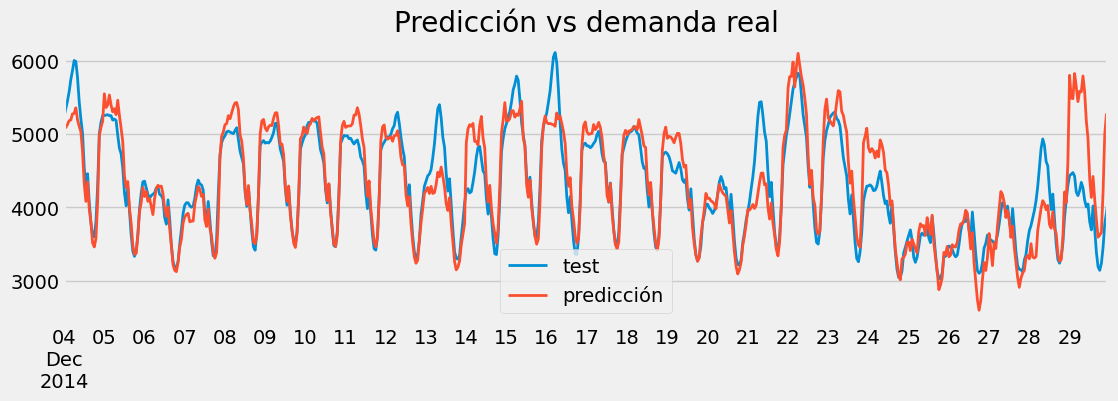

In [60]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(12, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [61]:
# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'Demand'],
            y_pred = predicciones
        )

print(f"Error de backtest: {error}")

Error de backtest: 238.1808028390107


En este caso, empleando un modelo gradient boosting (LGBMRegressor), la estrategia direct multi-step genera mejores resultados que la estrategia recursiva.